In [1]:
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset, load_dataset

In [2]:
# the code is adapted from the "fine-tuning a pretrained model" and
# "fine-tuning a model with the trainer API" course and examples on hugging face
# check huggingface for further explanations

# load data into training, valdidation and test
dataset = load_dataset('csv', data_files={'train':['hansen_d_bert_ds1.csv', 'hansen_d_bert_ds2.csv',
                                                   'hansen_d_bert_ds3.csv', 'hansen_d_bert_ds4.csv'],
                                          'validation':'hansen_d_bert_ds5.csv',
                                          'test': 'hansen_d_bert_ds6.csv'}, delimiter=',', column_names =['smiles', 'label'])

Using custom data configuration default-e7fa4e50daa5676d
Found cached dataset csv (C:/Users/pj11/.cache/huggingface/datasets/csv/default-e7fa4e50daa5676d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# check data format
dataset['validation'][1]

{'smiles': 'CC\\C(C)=N\\O', 'label': 14.7}

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# specify model from hugging face
tokenizer = AutoTokenizer.from_pretrained("deepchem/ChemBERTa-77M-MTR")

def tokenize_function(examples):
    return tokenizer(examples["smiles"], padding="max_length", truncation=True)

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\pj11\.cache\huggingface\datasets\csv\default-e7fa4e50daa5676d\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8e629755c8a0e61c.arrow
Loading cached processed dataset at C:\Users\pj11\.cache\huggingface\datasets\csv\default-e7fa4e50daa5676d\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-afe19ba60bc582e8.arrow
Loading cached processed dataset at C:\Users\pj11\.cache\huggingface\datasets\csv\default-e7fa4e50daa5676d\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-ebb54aff268407bd.arrow


In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
    test: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 197
    })
})

In [7]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=random_state).select(range(1000))
#small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=random_state).select(range(1000))

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["validation"]
small_test_dataset = tokenized_datasets["test"]

In [8]:
# for regression, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained("deepchem/ChemBERTa-77M-MTR", num_labels=1)

Some weights of the model checkpoint at deepchem/ChemBERTa-77M-MTR were not used when initializing RobertaForSequenceClassification: ['regression.out_proj.weight', 'regression.dense.bias', 'norm_std', 'norm_mean', 'regression.out_proj.bias', 'regression.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepchem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bia

In [9]:
import evaluate
import numpy as np

In [10]:
# define metric
mae_metric = evaluate.load("mae")
mse_metric = evaluate.load("mse")
pearsonr_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    # print(eval_pred)
    #logits, labels = eval_pred
    #predictions = np.argmax(logits, axis=-1)
    predictions, labels = eval_pred
    
    metrics = {}
    metrics.update({'mae': mae_metric.compute(predictions=predictions, references=labels)})
    metrics.update({'rmse': mse_metric.compute(predictions=predictions, references=labels, squared=False)})
    metrics.update({'pearsonr': pearsonr_metric.compute(predictions=predictions, references=labels)})
    
    return metrics

In [11]:
# directory to save the finetuned model
para_output_dir = 'C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/'
model_output_path = f'{para_output_dir}/model'

# specify trainining arguments 
training_args = TrainingArguments(output_dir=para_output_dir, 
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size = 4,
                                  per_device_eval_batch_size = 4,
                                  num_train_epochs=70)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [13]:
# finetuning
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 789
  Num Epochs = 70
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3500
  Number of trainable parameters = 3427825
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was

Epoch,Training Loss,Validation Loss,Mae,Rmse,Pearsonr
1,No log,228.964752,{'mae': 14.979710974593454},{'mse': 15.135946424237694},{'pearsonr': -0.3045547599299149}
2,No log,103.159172,{'mae': 9.97893736689224},{'mse': 10.160337065373533},{'pearsonr': 0.021224954714146715}
3,No log,76.303032,{'mae': 8.5359614875716},{'mse': 8.737992423183332},{'pearsonr': -0.02431046182088696}
4,No log,58.452232,{'mae': 7.418146419041048},{'mse': 7.648217882517792},{'pearsonr': -0.025552238557137872}
5,No log,44.309059,{'mae': 6.394450081181406},{'mse': 6.65935031315379},{'pearsonr': -0.02362946255468576}
6,No log,32.828758,{'mae': 5.422941546754789},{'mse': 5.732552060926986},{'pearsonr': -0.020798256322622465}
7,No log,23.563627,{'mae': 4.498151508079568},{'mse': 4.85724970932887},{'pearsonr': -0.017153802587210155}
8,No log,16.247843,{'mae': 3.615772339293194},{'mse': 4.033997419714882},{'pearsonr': -0.013756303344141074}
9,No log,10.712799,{'mae': 2.7702804458927988},{'mse': 3.2763231277518186},{'pearsonr': -0.008800079646650836}
10,72.035500,6.817681,{'mae': 2.0239434266453467},{'mse': 2.614476935491016},{'pearsonr': -0.0022682795254390965}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\ncc

Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-1500
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-1500\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-1500\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-pack

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-2000
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-2000\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-2000\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1/checkpoint-2500
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_f

***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: Use

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 197
  Batch size = 16
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

TrainOutput(global_step=3500, training_loss=11.158131356375558, metrics={'train_runtime': 393.6296, 'train_samples_per_second': 140.31, 'train_steps_per_second': 8.892, 'total_flos': 508877689743360.0, 'train_loss': 11.158131356375558, 'epoch': 70.0})

In [14]:
#take care of distributed/paralelle training 
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model 
model_to_save.save_pretrained(model_output_path)

Configuration saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model\pytorch_model.bin


In [15]:
# making prediction 
model = AutoModelForSequenceClassification.from_pretrained(model_output_path)

# arguments for Trainer
test_args = TrainingArguments(
     output_dir =model_output_path,
     do_train = False,
     do_predict = True,
     dataloader_drop_last = False
)

# Init Trainer
trainer=Trainer(
          model = model,
          args = test_args,
          compute_metrics = compute_metrics)

test_results = trainer.predict(small_test_dataset)

loading configuration file C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model\config.json
Model config RobertaConfig {
  "_name_or_path": "C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.109,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.144,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 464,
  "is_gpu": true,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 515,
  "model_type": "roberta",
  "norm_mean": [
    11.199569164274653,
    -0.9728601944583675,
    11.199595401578872,
    0.1914454376660732,
    0.608589373135307,
    365.064017672,
    342.24912812000014,
    364.6033136038417,
    134.06547,
    0.004249,
    0.0,
    0.0,
    0.

loading weights file C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model\pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at C:/Users/pj11/Documents/bert_finetune2/hansen_d_fold1//model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected

In [16]:
# print out prediction in test set
test_results[1]

array([16.8, 16. , 15.6, 15.7, 17.8, 15.9, 17.2, 17.2, 18.8, 16. , 17.8,
       16.5, 15. , 20. , 20. , 15.2, 15.4, 19.9, 20.2, 14. , 16. , 21. ,
       14.4, 16.8, 17. , 19.4, 15.9, 15.8, 19.6, 19.5, 17.8, 18.7, 19. ,
       19.2, 16.3, 20.3, 16.5, 17.1, 15.8, 18.3, 15.4, 15.4, 20.9, 15.3,
       15.7, 15. , 17.5, 14.7, 15.8, 16. , 19.9, 19. , 15.5, 19.8, 18.5,
       20.3, 16.5, 15.7, 15.7, 15.4, 15.8, 16.8, 16.2, 19. , 16.8, 16.4,
       14.5, 18.7, 18.7, 19. , 16.3, 15.1, 16.8, 20.2, 14.9, 18.2, 20.5,
       18.2, 14.6, 19.1, 15. , 16.4, 15.5, 20.4, 20.1, 15. , 16. , 15.9,
       16.7, 20. , 15.5, 19.2, 15.6, 19.5, 17.3, 16.3, 16.4, 20.2, 17.5,
       17.2, 16.1, 19.8, 18.7, 20. , 19. , 19.4, 15.3, 16.5, 19.5, 16.2,
       20. , 16.9, 15.6, 17.4, 19. , 20. , 20. , 15.8, 19.5, 15.6, 17.5,
       13.7, 19. , 19.2, 17.8, 16. , 16.3, 14.8, 16. , 15.3, 16.1, 17.8,
       17.4, 21.3, 20.2, 18.9, 18.9, 20.7, 14.4, 20. , 17.6, 12.2, 14.6,
       15.2, 16.8, 16.4, 16. , 18.2, 16. , 18.1, 17

In [17]:
# print out metric in test set
test_results[2]

{'test_loss': 0.827226996421814,
 'test_mae': {'mae': 0.6462542877584545},
 'test_rmse': {'mse': 0.909957019184815},
 'test_pearsonr': {'pearsonr': 0.880799222914437},
 'test_runtime': 1.045,
 'test_samples_per_second': 188.523,
 'test_steps_per_second': 6.699}

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(test_results[0], test_results[1]))

#RMSEs
print(math.sqrt(mean_squared_error(test_results[0], test_results[1])))

# R^2 Coefficient of Determination
print(r2_score(test_results[0], test_results[1]))

0.64625436
0.9099570453377971
0.6845268369984588


Text(0, 0.5, 'pred. Hansen d')

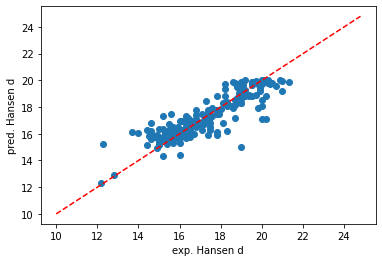

In [19]:
# plot exp vs pred in test set
import matplotlib.pyplot as plt
plt.figure(1)

ln = np.arange(10, 25, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(test_results[1], test_results[0])
plt.xlabel('exp. Hansen d')
plt.ylabel('pred. Hansen d')

In [20]:
pd_pred_test=pd.DataFrame(test_results[0], columns=["predict"])
pd_exp_test=pd.DataFrame(test_results[1], columns=["exp"])
pd_smiles=pd.DataFrame(dataset['test']['smiles'], columns=["smiles"])
pd_test=pd.concat((pd_smiles, pd_exp_test, pd_pred_test), axis=1)

# save predicton to csv 
pd_test.to_csv('hansen_d_bert_ds6_fold1_results_v2.csv')

In [ ]:
pd_test